## LONG SHORT-TERM MEMORY (LSTM) UNTUK PERAMALAN HARGA TANDAN BUAH SEGAR (TBS)

**Import Library**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

**Import Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/SKRIPSI/harga_tbs.csv'

df = pd.read_csv(file_path)
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Tanggal,Harga_CPO,Harga_Kernel,Indeks_K,Harga_TBS
0,1/1/2014,"8,751.71","5,537.80",88.82,"1,950.93"
1,8/1/2014,"8,858.36","5,614.35",88.51,"1,968.08"
2,15/01/2014,"8,715.29","5,585.42",88.25,"1,933.36"
3,22/01/2014,"8,630.70","5,626.46",88.82,"1,931.47"
4,29/01/2014,"8,833.28","5,769.18",88.57,"1,971.65"
...,...,...,...,...,...
552,27/11/2024,"15,152.24","11,211.55",92.84,"3,668.47"
553,4/12/2024,"15,293.38","11,458.24",92.84,"3,709.19"
554,11/12/2024,"15,774.13","11,794.66",92.84,"3,824.03"
555,18/12/2024,"15,639.51","11,866.30",93.30,"3,819.14"


## Preprocessing Data

**Cek Missing Value**

In [ ]:
# Memeriksa jumlah nilai null (missing values) dalam setiap kolom
df.isnull().sum()

,0
Tanggal,0
Harga_CPO,0
Harga_Kernel,0
Indeks_K,0
Harga_TBS,0


**Seleksi Data**

In [ ]:
# Fitur input dan target
input_features = ['Harga_CPO', 'Harga_Kernel', 'Indeks_K']  # Input
target_feature = 'Harga_TBS'  # Target

**Pembersihan Data**

In [ ]:
# Bersihkan data dari tanda koma dan ubah menjadi float
for col in input_features + [target_feature]:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace(',', '').astype(float)
print(df.head())

      Tanggal  Harga_CPO  Harga_Kernel  Indeks_K  Harga_TBS
0    1/1/2014    8751.71       5537.80     88.82    1950.93
1    8/1/2014    8858.36       5614.35     88.51    1968.08
2  15/01/2014    8715.29       5585.42     88.25    1933.36
3  22/01/2014    8630.70       5626.46     88.82    1931.47
4  29/01/2014    8833.28       5769.18     88.57    1971.65


**Grafik Rata-rata Harga TBS 2014-2024**

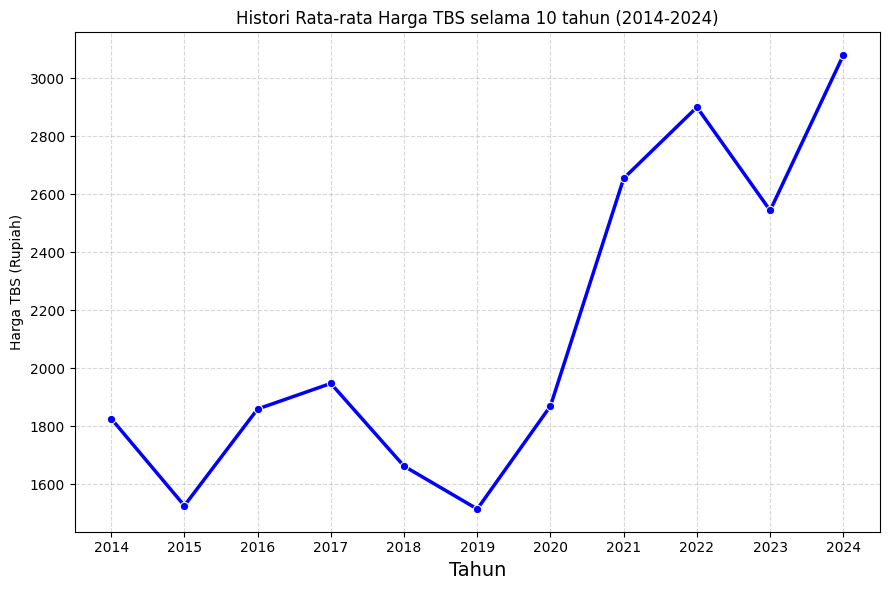

In [ ]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'], dayfirst=True)
df['Harga_TBS'] = df['Harga_TBS']
df['Tahun'] = df['Tanggal'].dt.year
df_tahunan = df.groupby('Tahun', as_index=False)['Harga_TBS'].mean()

plt.figure(figsize=(9, 6))
sns.lineplot(x="Tahun", y="Harga_TBS", data=df_tahunan, marker="o", linewidth=2.5, color="blue")
plt.title("Histori Rata-rata Harga TBS selama 10 tahun (2014-2024)")
plt.xlabel("Tahun", fontsize=14)
plt.ylabel("Harga TBS (Rupiah)")
plt.grid(visible=True, linestyle="--", alpha=0.5)
plt.xticks(df_tahunan['Tahun'])
plt.tight_layout()
plt.show()

**Normalization**

Mengubah nilai-nilai ke dalam range antara 0 dan 1

In [ ]:
# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df[input_features + [target_feature]])

print("Data setelah normalisasi:")
print(data_scaled)

Data setelah normalisasi:
[[0.28729535 0.25153138 0.52941176 0.26955276]
 [0.2960529  0.25823007 0.49684874 0.27501393]
 [0.28430473 0.25569848 0.46953782 0.26395784]
 ...
 [0.86394056 0.79905317 0.95168067 0.86601493]
 [0.85288626 0.8053222  1.         0.86445778]
 [0.81320588 0.76948353 1.         0.82643973]]


**Data split & Time series windowing**

melakukan pembagian data menjadi data train dan data test dengan perbandingan 80:20, serta melakukan penyesuaian dimensi data untuk digunakan dalam model LSTM. Dilakukan juga reshapping atau mengubah bentuk dari masing-masing input data yang telah disiapkan menjadi tiga dimensi, yaitu (jumlah sampel, jumlah time steps, jumlah fitur) agar dapat digunakan sebagai input dalam model LSTM.

In [ ]:
# Pisahkan data training (2014-2023) dan testing (2024)
df_train = df[df['Tahun'] <= 2023]
df_test = df[df['Tahun'] == 2024]

# Bagi df_train menjadi 90% training dan 10% validation
train_size = int(len(df_train) * 0.9)
df_train_main = df_train.iloc[:train_size]  # 90% training
df_val = df_train.iloc[train_size:]         # 10% validation

# ======================================
# Perubahan di sini: Scaling data yang dipisahkan
# ======================================
train_scaled = scaler.transform(df_train_main[input_features + [target_feature]])
val_scaled = scaler.transform(df_val[input_features + [target_feature]])
test_scaled = scaler.transform(df_test[input_features + [target_feature]])
# ======================================

In [ ]:
# Fungsi untuk membuat dataset time series
def create_dataset(dataset, look_back=3):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :-1])  # Semua fitur kecuali target
        Y.append(dataset[i + look_back, -1])      # Hanya target
    return np.array(X), np.array(Y)

# Buat dataset untuk training, validation, dan testing
look_back = 3
X_train, Y_train = create_dataset(train_scaled, look_back)
X_val, Y_val = create_dataset(val_scaled, look_back)
X_test, Y_test = create_dataset(test_scaled, look_back)

# Reshape input untuk LSTM
X_train = X_train.reshape((X_train.shape[0], look_back, len(input_features)))
X_val = X_val.reshape((X_val.shape[0], look_back, len(input_features)))
X_test = X_test.reshape((X_test.shape[0], look_back, len(input_features)))

# Cek bentuk dataset
print(f"Bentuk X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"Bentuk X_test: {X_test.shape}, Y_test: {Y_test.shape}")

Bentuk X_train: (455, 3, 3), Y_train: (455,)
Bentuk X_test: (45, 3, 3), Y_test: (45,)


## Modelling

**Arsitektur LSTM**

* Dilakukan inisialisasi hyperparameter.

* Model LSTM dibuat dengan menggunakan objek Sequential dari library Keras.

* Ditambahkan sebuah layer Dense dengan 1 neuron yang berfungsi untuk menghasilkan output berupa harga TBS.

* Model dicompile dengan menggunakan optimizer Adam dan loss function mse, yang akan digunakan untuk mengukur seberapa besar selisih antara hasil prediksi dengan nilai yang sebenarnya.

* Model dilatih dengan menggunakan fungsi fit() yang memasukkan input dan output data training serta beberapa parameter seperti jumlah epoch, jumlah batch, dan validation data.

In [ ]:
#Inisialisasi Hyperparameter
num_neuron = 40
num_epochs = 100
num_batch = 16

# Layer LSTM
model = Sequential()
model.add(LSTM(num_neuron, input_shape=(look_back, X_train.shape[2])))
model.add(Dense(1))  # Output hanya untuk Harga TBS
model.compile(optimizer='adam', loss='mean_squared_error')

# Ringkasan model
model.summary()

# Training model
history = model.fit(X_train, Y_train, epochs=num_epochs, batch_size=num_batch, validation_data=(X_test, Y_test), verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 40)                  │           7,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              41 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,081 (27.66 KB)

 Trainable params: 7,081 (27.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0927 - val_loss: 0.0451
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0123 - val_loss: 0.0358
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0086 - val_loss: 0.0189
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048 - val_loss: 0.0105
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - val_loss: 0.0037
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024 - val_loss: 0.0046
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - val_loss: 7.1188e-04
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss

**Loss Visualization**

- untuk membandingkan perubahan nilai loss dan val loss selama proses pelatihan.
- membantu dalam mengevaluasi kinerja model terhadap data pelatihan dan data validasi.

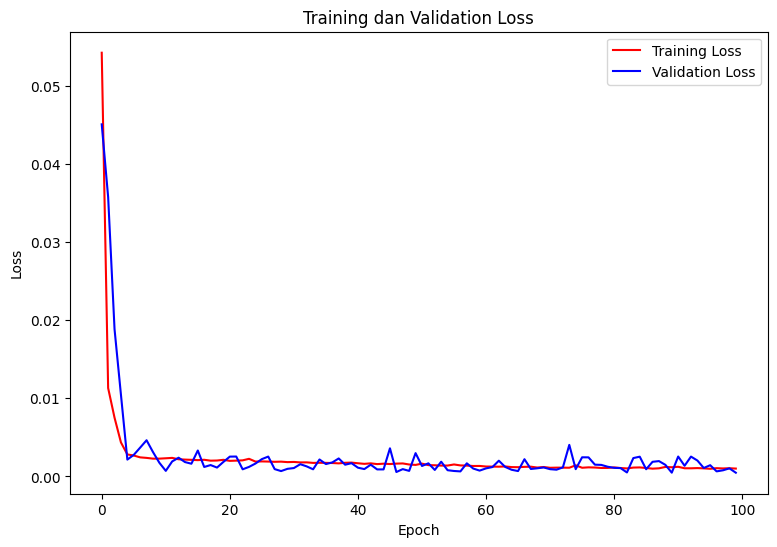

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(history.history['loss'], label='Training Loss', color="red")
plt.plot(history.history['val_loss'], label='Validation Loss', color="blue")
plt.title('Training dan Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

pada grafik diatas nilai loss pada data training dan data validasi sama-sama menurun seiring dengan bertambahnya jumlah epoch, maka dapat dikatakan model tersebut memperlihatkan performa yang baik dalam melakukan prediksi harga TBS.

## Pengujian Model

Kemudian dilakukan prediksi pada data testing (2024), lalu dilakukan invers scalinng agar data dapat ditampilkan dalam satuan yang sesuai dengan konteks awal.

In [ ]:
# Prediksi pada data uji (2024)
predictions = model.predict(X_test)

# Kembalikan ke skala asli
Y_test_actual = scaler.inverse_transform(np.hstack((np.zeros((len(Y_test), len(input_features))), Y_test.reshape(-1, 1))))[:, -1]
predictions_actual = scaler.inverse_transform(np.hstack((np.zeros((len(predictions), len(input_features))), predictions)))[:, -1]

# Ambil tanggal yang sesuai dengan data uji
# Replace len(train) with len(df_train_main)
# Ambil hanya data tahun 2024
# Ambil tanggal dari df_test, tapi geser indeks berdasarkan look_back
test_dates = df_test['Tanggal'].iloc[look_back:].reset_index(drop=True)

# Membuat DataFrame perbandingan antara Harga Aktual dan Harga Prediksi
df_comparison = pd.DataFrame({
    "Tanggal": test_dates.values,
    "Harga Aktual": Y_test_actual,
    "Harga Prediksi": predictions_actual
})

print("Perbandingan Data Aktual dan Prediksi:")
print(df_comparison.head(50))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
Perbandingan Data Aktual dan Prediksi:
      Tanggal  Harga Aktual  Harga Prediksi
0  2024-01-24       2726.18     2668.096944
1  2024-02-07       2639.42     2738.276227
2  2024-02-14       2642.04     2679.307963
3  2024-02-21       2664.75     2670.760320
4  2024-02-28       2716.26     2679.460702
5  2024-03-06       2762.97     2713.279535
6  2024-03-20       2907.07     2772.552153
7  2024-03-27       2956.83     2901.578689
8  2024-04-03       2968.36     2970.039571
9  2024-04-24       2912.28     3000.050801
10 2024-05-01       2843.45     2993.061520
11 2024-05-08       2806.33     2895.714357
12 2024-05-15       2820.89     2820.677112
13 2024-05-22       2819.55     2819.133256
14 2024-05-29       2847.70     2827.930315
15 2024-06-05       2914.91     2859.224472
16 2024-06-12       2899.39     2912.960322
17 2024-06-19       2924.72     2908.700867
18 2024-06-26       2965.32     2927.995698
19 2024-07-03       2969.51     2966.15447

**Grafik Perbandingan Harga TBS Aktual dan Prediksi**

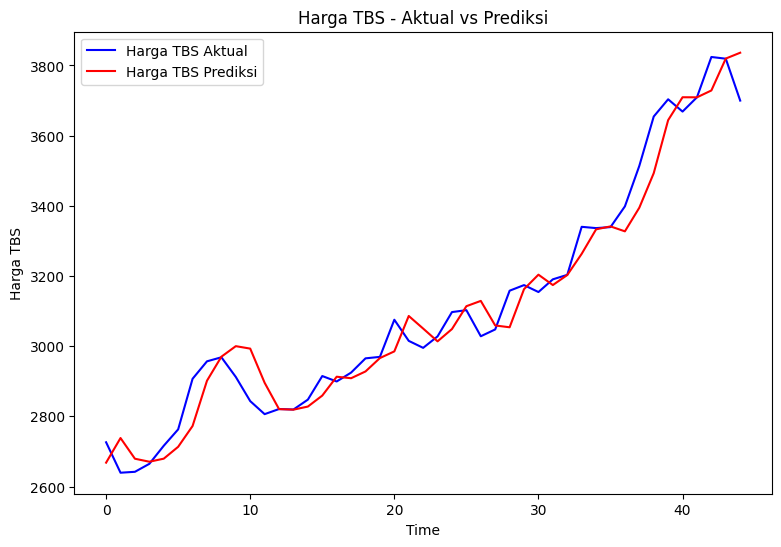

In [ ]:
# Visualisasi hasil
plt.figure(figsize=(9, 6))
plt.plot(Y_test_actual, label='Harga TBS Aktual', color='blue')
plt.plot(predictions_actual, label='Harga TBS Prediksi', color='red')
plt.title('Harga TBS - Aktual vs Prediksi')
plt.xlabel('Time')
plt.ylabel('Harga TBS')
plt.legend()
plt.show()

## Evaluasi Model

Kemudian akan dilakukan evaluasi menggunakan metrik evaluasi MSE, RMSE, MAE dan MAPE.

In [ ]:
# Evaluasi model
mse = mean_squared_error(Y_test_actual, predictions_actual)
mae = mean_absolute_error(Y_test_actual, predictions_actual)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((Y_test_actual - predictions_actual) / Y_test_actual)) * 100

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")

MSE: 4666.282667023737
RMSE: 68.31019445898055
MAE: 51.156552429265474
MAPE: 1.6432509902539156%


## Prediksi Harga TBS Untuk Periode Ke Depan

Melakukan peramalan masa depan (future forecasting) menggunakan model yang telah dilatih. Tujuannya adalah untuk memberikan gambaran tentang prediksi nilai masa depan pada model yang telah dilatih, sehingga dapat digunakan sebagai acuan untuk pengambilan keputusan pada masa depan.

In [ ]:
# Prediksi Tren Masa Depan
n_weeks = 52  # Prediksi 52 minggu ke depan
future_predictions = []
future_cpo = []
future_kernel = []
future_indeks_k = []

# Ambil urutan data terakhir dari X_test sebagai input awal
input_seq = X_test[-1]  # Mulai dari data uji terakhir

# Define time_step using look_back
time_step = look_back # or directly use look_back in the reshape method

for i in range(n_weeks):
    # Reshape input_seq using time_step
    pred = model.predict(input_seq.reshape(1, time_step, len(input_features)))
    # Updated to use input_features instead of relying on 'features'
    # which was not defined.
    future_predictions.append(pred.flatten())

    # Simpan nilai input lainnya (CPO, Kernel, Indeks_K)
    future_cpo.append(input_seq[-1, 0])  # Harga CPO
    future_kernel.append(input_seq[-1, 1])  # Harga Kernel
    future_indeks_k.append(input_seq[-1, 2])  # Indeks K

    # Update input_seq untuk iterasi selanjutnya
    new_input = np.hstack((input_seq[-1, 1:], pred.flatten()))  # Gabungkan input baru
    input_seq = np.append(input_seq[1:], new_input.reshape(1, -1), axis=0)

# Kembalikan prediksi masa depan ke skala asli
# Create an array with the correct shape for inverse_transform
future_predictions_data = np.zeros((n_weeks, len(input_features) + 1)) # +1 for the target feature
future_predictions_data[:, :-1] = np.hstack((
    np.array(future_cpo).reshape(-1, 1),
    np.array(future_kernel).reshape(-1, 1),
    np.array(future_indeks_k).reshape(-1, 1)
))
future_predictions_data[:, -1] = np.array(future_predictions).reshape(-1)

future_predictions_scaled = scaler.inverse_transform(future_predictions_data)[:, -1]

# Inverse transform untuk Harga_CPO, Harga_Kernel, dan Indeks_K (No change needed here)
future_features_scaled = scaler.inverse_transform(
    np.hstack((
        np.array(future_cpo).reshape(-1, 1),  # Harga_CPO
        np.array(future_kernel).reshape(-1, 1),  # Harga_Kernel
        np.array(future_indeks_k).reshape(-1, 1),  # Indeks_K
        np.zeros((n_weeks, 1))  # Placeholder untuk Harga_TBS
    ))
)

future_cpo_scaled = future_features_scaled[:, 0]
future_kernel_scaled = future_features_scaled[:, 1]
future_indeks_k_scaled = future_features_scaled[:, 2]

# Format ulang data (opsional untuk angka dengan tanda pemisah ribuan)
def format_value(value, decimal=2):
    return f"{value:,.{decimal}f}"

# Buat DataFrame untuk prediksi tren lengkap dengan Harga_CPO, Harga_Kernel, Indeks_K
future_dates = pd.date_range(start=df['Tanggal'].iloc[-1], periods=n_weeks + 1, freq='W')[1:]
df_future = pd.DataFrame({
    'Tanggal': future_dates,
    'Harga_CPO': [format_value(v) for v in future_cpo_scaled],
    'Harga_Kernel': [format_value(v) for v in future_kernel_scaled],
    'Indeks_K': [format_value(v, decimal=2) for v in future_indeks_k_scaled],
    'Harga_TBS': future_predictions_scaled
})

# Tampilkan hasil prediksi tren masa depan
print("Prediksi Tren Harga TBS untuk Tahun 2025:")
print(df_future.head(52))

# Simpan ke dalam file CSV
df_future.to_csv("/content/tren_harga_tbs_2025.csv", index=False)

print("Prediksi disimpan dalam file CSV: 'tren_harga_tbs_2025.csv'")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/ste

**Grafik Prediksi Harga TBS untuk Tahun 2025**

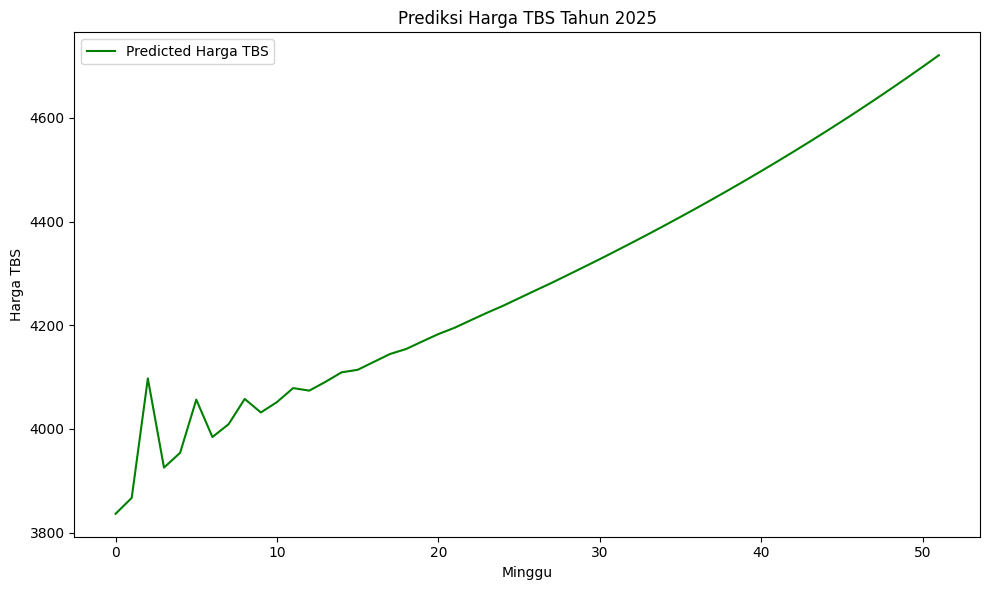

In [ ]:
# Visualisasi prediksi Harga TBS
plt.figure(figsize=(10, 6))
# Changed future_df to df_future
plt.plot(df_future.index, df_future['Harga_TBS'], label='Predicted Harga TBS', color='green')
plt.title('Prediksi Harga TBS Tahun 2025')
plt.xlabel('Minggu')
plt.ylabel('Harga TBS')
plt.legend()
plt.tight_layout()
plt.show()